In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/petfinder ./

In [1]:
%cd petfinder


/content/petfinder


In [4]:
!unzip -qq petfinder-adoption-prediction.zip

In [2]:
import cv2
import pandas as pd
import numpy as np
import os
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from keras.applications.resnet import preprocess_input, ResNet101
from keras.utils import to_categorical
from dataset import My_Custom_Generator

In [3]:
path = 'train/train.csv'
df_pet = pd.read_csv(path)
df = df_pet[['PetID','PhotoAmt','AdoptionSpeed']]
df = df[df['PhotoAmt']>0]
df.head()

,PetID,PhotoAmt,AdoptionSpeed
0,86e1089a3,1.0,2
1,6296e909a,2.0,0
2,3422e4906,7.0,3
3,5842f1ff5,8.0,2
4,850a43f90,3.0,2


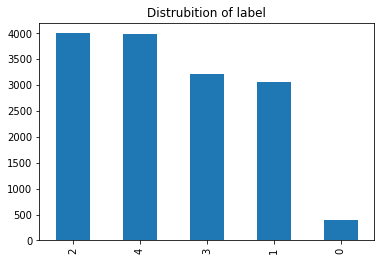

In [4]:
df['AdoptionSpeed'].value_counts().plot(kind='bar')
plt.title("Distrubition of label")
plt.show()

In [5]:
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image


In [6]:
img_size = 256
batch_size = 16
n_classes = 5

In [7]:
pet_ids = df['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

In [8]:
X = []
y = []
# max_images = 100
for index, row in df.iterrows():
    # img = load_image("train_images/", row['PetID'])
    for count in range(int(row['PhotoAmt'])):
      name = f"{row['PetID']}-{count+1}.jpg"
      imgName = os.path.join("train_images/", name)
      X.append(imgName)
      y.append(row['AdoptionSpeed'])
    # if index > max_images:
    #     break


In [9]:
len(X)

58311

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

batch_size = 32
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

my_training_batch_generator = My_Custom_Generator(x_train, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(x_val, y_val, batch_size)
print(my_validation_batch_generator)

In [15]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D, Dense
import keras.backend as K
import keras
inp = Input((256,256,3))
backbone = ResNet101(input_tensor = inp, include_top = False)
# for layer in backbone.layers:
#     layer.trainable = False
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(4096)(x)
x = Dense(4096)(x)
out = Dense(n_classes, activation='softmax')(x)
m = Model(inp,out)

m.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics= 'accuracy')

In [16]:
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [17]:
m.fit_generator(generator = my_training_batch_generator,
                steps_per_epoch = int(3800 // batch_size),
                epochs=100, 
                validation_data = my_validation_batch_generator,
                validation_steps = int(950 // batch_size))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
118/118 [==============================] - 162s 1s/step - loss: 228.3708 - accuracy: 0.2095 - val_loss: 4.6717 - val_accuracy: 0.3028
Epoch 2/100
118/118 [==============================] - 149s 1s/step - loss: 18.6842 - accuracy: 0.2586 - val_loss: 1.9579 - val_accuracy: 0.3028
Epoch 3/100
118/118 [==============================] - 149s 1s/step - loss: 4.8154 - accuracy: 0.2532 - val_loss: 1.4940 - val_accuracy: 0.3028
Epoch 4/100
118/118 [==============================] - 148s 1s/step - loss: 2.4915 - accuracy: 0.2579 - val_loss: 1.4748 - val_accuracy: 0.2694
Epoch 5/100
118/118 [==============================] - 151s 1s/step - loss: 1.7726 - accuracy: 0.2487 - val_loss: 1.4598 - val_accuracy: 0.2694
Epoch 6/100
118/118 [==============================] - 150s 1s/step - loss: 1.5810 - accuracy: 0.2726 - val_loss: 1.4580 - val_accuracy: 0.2220
Epoch 7/100
118/118 [==============================] - 149s 1s/step - loss: 1.5065 - accuracy: 0.2785 - val_loss: 1.4564 - val_accura